## Notebook Purpose

now that dd+ has been drastically simplified/streamlined in qdess expmt, make this compatible for fastmri expmts

In [1]:
import os, sys
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.data_io import load_h5#, load_output, save_output, \
#                             expmt_already_generated
# from utils.transform import np_to_tt, split_complex_vals, recon_ksp_to_img
# from include.mri_helpers import get_scale_factor, get_masked_measurements, \
#                                 data_consistency
from utils.helpers import num_params#, get_masks
from include.decoder_conv import init_convdecoder
from include.fit import fit
from include.subsample import MaskFunc
from utils.evaluate import calc_metrics
from utils.transform import fft_2d, ifft_2d, root_sum_squares, \
                            reshape_complex_vals_to_adj_channels, \
                            reshape_adj_channels_to_complex_vals, \
                            crop_center

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(2)
else:
    dtype = torch.FloatTensor

In [2]:
def plot_list(arr_list):
    
    NUM_COLS = len(arr_list)
    title_list = ['gt', 'est', 'dc']
    
    fig = plt.figure(figsize=(20,20))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        ax.imshow(arr_list[idx], cmap='gray')
        ax.set_title(title_list[idx])
        ax.axis('off')
    plt.show()

### Run expmts

In [3]:
file_id = '1001798' #'1000273'
f, ksp_orig = load_h5(file_id)

ksp_orig = torch.from_numpy(ksp_orig)
ksp_orig.shape

torch.Size([15, 640, 372])

### want mask to be 1d, length 372

(nc, kx, ky) = (15, 640, 372). want to fully sample kx and undersample ky

In [4]:
def get_mask(ksp_orig, center_fractions=[0.07], accelerations=[4]):
    ''' simplified version of get_masks() in utils.helpers -- return only a 1d mask in torch tensor '''
        
    mask_func = MaskFunc(center_fractions=center_fractions, \
                             accelerations=accelerations)
    
    # note: had to swap dims to work w facebook's MaskFunc class
    mask_shape = (1, ksp_orig.shape[2], ksp_orig.shape[1])
    
    mask = mask_func(mask_shape, seed=0)

    return mask[0,:,0].type(torch.uint8)

In [5]:
mask = get_mask(ksp_orig)
mask.shape

torch.Size([372])

### init network

In [32]:
net, net_input, ksp_orig_ = init_convdecoder(ksp_orig, mask)

89630507.82682784
tensor(1540.6342) tensor(1.7189e-05)
tensor(89630408.)


### apply mask

In [8]:
ksp_masked = ksp_orig_ * mask # should be ksp_orig_
img_masked = ifft_2d(ksp_masked)

ksp_orig.shape, ksp_masked.shape, img_masked.shape

(torch.Size([15, 640, 372]),
 torch.Size([15, 640, 372]),
 torch.Size([15, 640, 372]))

In [9]:
net, mse_wrt_ksp, mse_wrt_img = fit(
    ksp_masked=ksp_masked, img_masked=img_masked,
    net=net, net_input=net_input, mask2d=mask, num_iter=1000)

In [10]:
img_out = net(net_input.type(dtype))[0]
img_out.shape, img_out.dtype

(torch.Size([30, 640, 372]), torch.float32)

In [11]:
# make complex tensor [nc,x,y] from [2*nc,x,y]
img_out = reshape_adj_channels_to_complex_vals(img_out)

ksp_est = fft_2d(img_out)

# apply dc step
ksp_dc = torch.where(mask, ksp_masked, ksp_est) 

In [12]:
dim = 320

img_est = crop_center(root_sum_squares(ifft_2d(ksp_est)).detach(), dim, dim)
img_dc = crop_center(root_sum_squares(ifft_2d(ksp_dc)).detach(), dim, dim)
img_gt = crop_center(root_sum_squares(ifft_2d(ksp_orig)), dim, dim)

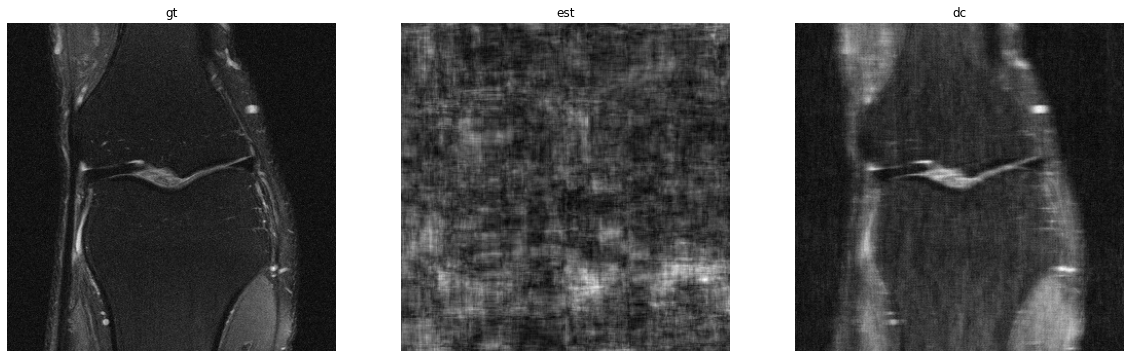

In [13]:
plot_list([img_gt, img_est, img_dc])

# TODO: why are recons wonky?
    
- this seems to be a scaling issue. see below output to tune scaling factor, then try running this over some different images
    - tuning scaling factor: takes images from awful to decent, but perhaps not quite perfect? checking on this w 10000 iter. if works, do manual scaling factor
    - 
    
- are we sure it's due to scaling factor? on two samples, a manual sf fixed it. check for relationship in the modified scaling factor. i.e. maybe we can just multiply it by a constant fraction each time?


- intuition: we want network input to be scaled s.t. norm(orig_img) created doing ifft of ksp_orig ~= norm(orig_img) created using randomly initialized weights and net_input ~U[0,1]


- what's not an issue
    - new way of computing scaling factor. everything thoroughly checked except for different versions of pytorch ifft_2d() v ifft2() when calculating norm(orig_img). --> very unlikely this is an issue
    - new way of computing / applying mask

In [16]:
def norm(arr):
    return torch.linalg.norm(abs(arr))

print(norm(ksp_orig), norm(ksp_orig_))

tensor(0.0084) tensor(751725.8125)


### try recon over span of scaling factors, 

i.e. from 1 --> 89630408, and see if any of the output is decent. if it's all shit, then might not be a scaling issue

In [27]:
sf_list = []

for e in np.arange(9):
    sf_list.append(10**e)
    
sf_list

[1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]

below we're literally manually inserting the sf into the process. so if this works, why did previous one fail? must have been an implementation issue...

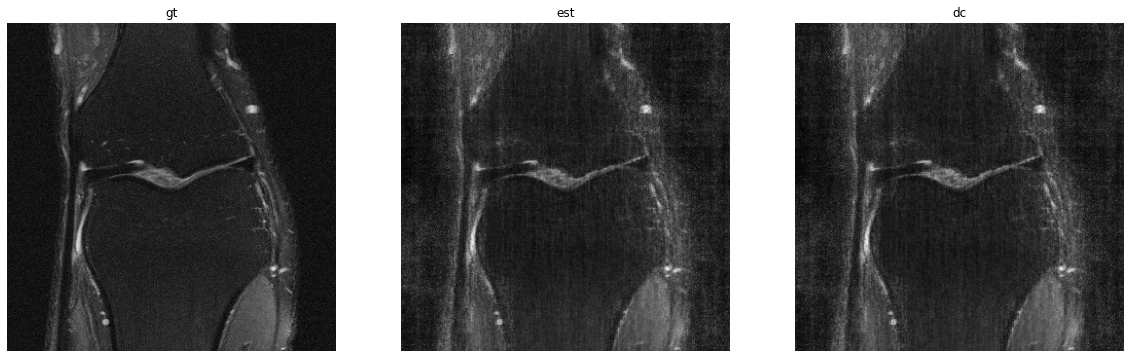

In [34]:
dim = 320

sf_list_best = 10000000 # when sf=89630408 on samp '1001798'

for sf in [89630408]:#sf_list[5:]:
    
    ksp_orig_ = sf * ksp_orig
    
    ksp_masked = ksp_orig_ * mask # should be ksp_orig_
    img_masked = ifft_2d(ksp_masked)
    
    net, mse_wrt_ksp, mse_wrt_img = fit(
        ksp_masked=ksp_masked, img_masked=img_masked,
        net=net, net_input=net_input, mask2d=mask, num_iter=10000)
    
    img_out = net(net_input.type(dtype))[0]
    img_out = reshape_adj_channels_to_complex_vals(img_out)
    ksp_est = fft_2d(img_out)
    ksp_dc = torch.where(mask, ksp_masked, ksp_est) 
    
    img_est = crop_center(root_sum_squares(ifft_2d(ksp_est)).detach(), dim, dim)
    img_dc = crop_center(root_sum_squares(ifft_2d(ksp_dc)).detach(), dim, dim)
    img_gt = crop_center(root_sum_squares(ifft_2d(ksp_orig)), dim, dim)
    
    plot_list([img_gt, img_est, img_dc])

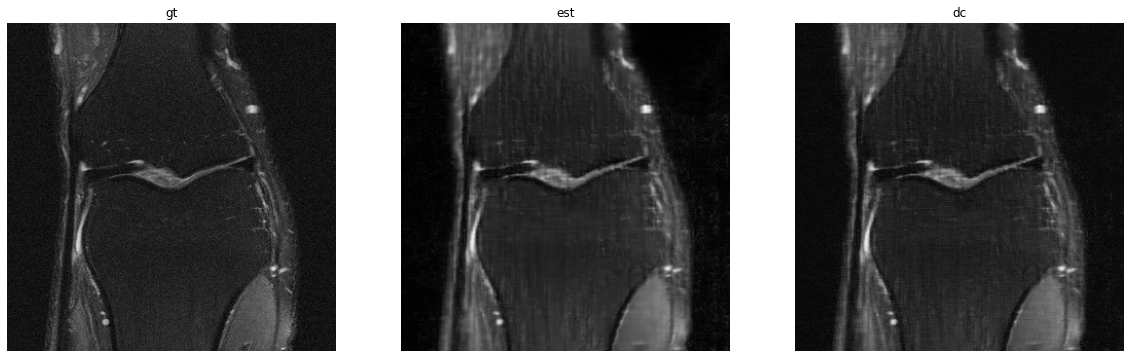

In [29]:
# above code when sf = 10000000

# OLD

code used to debug a potential scaling issue -- no apparent difference b/w old and new ways of computing scaling factor

In [31]:
from include.decoder_conv import convdecoder
from torch.autograd import Variable

def split_complex_vals(ksp):
    ''' given complex npy array, split real/complex vals into two channels 
        e.g. shape (15,x,y) --> (15,x,y,2) '''
    return np.transpose(np.array([np.real(ksp),np.imag(ksp)]), (1, 2, 3, 0))

def channels2imgs(out): #TODO: replace this function via utils.transform.py
    sh = out.shape
    chs = int(sh[0]/2)
    imgs = np.zeros( (chs,sh[1],sh[2]) )
    for i in range(chs):
        imgs[i] = np.sqrt( out[2*i]**2 + out[2*i+1]**2 )
    return imgs

def root_sum_of_squares(data, dim=0):
    return torch.sqrt((data ** 2).sum(dim))

def complex_abs(data):
    assert data.size(-1) == 2
    return (data ** 2).sum(dim=-1).sqrt()

def init_convdecoder(ksp_orig, mask, \
                     in_size=[8,4], num_layers=8, num_channels=160, kernel_size=3):
    ''' wrapper function for initializing convdecoder based on input ksp_orig

        parameters:
                ksp_orig: original, unmasked k-space measurements
                mask: mask used to downsample original k-space
        return:
                net: initialized convdecoder
                net_input: random, scaled input seed
                ksp_orig: scaled version of input '''

    out_size = ksp_orig.shape[1:] # shape of (x,y) image slice, e.g. (640, 368)
    out_depth = ksp_orig.shape[0]*2 # 2*n_c, i.e. 2*15=30 if multi-coil
    strides = [1]*(num_layers-1)

    net = convdecoder(in_size, out_size, out_depth, num_layers, \
                      strides, num_channels).type(dtype)
    
    net_input = get_net_input(num_channels, in_size)
    
    scale_factor_old, _ = get_scale_factor_old(net, net_input, ksp_orig)
    print(scale_factor_old)

    # create scaled ksp to be compatible w network magnitude
    scale_factor = get_scale_factor(net, net_input, ksp_orig)
    print(scale_factor)
    ksp_orig_ = ksp_orig * scale_factor

    return net, net_input, ksp_orig_

def get_net_input(num_channels, in_size):
    ''' return net_input, e.g. tensor w values samples uniformly on [0,1] '''

    shape = [1, num_channels, in_size[0], in_size[1]]
    net_input = Variable(torch.zeros(shape)).type(dtype)
    torch.manual_seed(0)
    net_input.data.uniform_()

    return net_input

def get_scale_factor_old(net, net_input, slice_ksp):
    ''' return net_input, e.g. tensor w values sampled uniformly on [0,1]
        return scaling factor, i.e. difference in magnitudes scaling b/w:
        original image and random image of network output = net(net_input) '''

    # this is the same
    out_chs = net(net_input.type(dtype)).data.cpu().numpy()[0]
    out_imgs = channels2imgs(out_chs) # combine adjacent channels into real-valued [nc,x,y]
    out_img_tt = root_sum_of_squares(torch.tensor(out_imgs), dim=0) # rss across nc, i.e. [x,y]

    ### get norm of least-squares reconstruction -- seems to be the same as new function
#     ksp_tt = transform.to_tensor(slice_ksp) # stack along last dimension so its (nc,x,y,2) 
#     orig_tt = transform.ifft2(ksp_tt)   # apply ifft get the complex image in (nc,x,y,2)
    orig_tt = ifft_2d(slice_ksp)
    orig_tt = torch.from_numpy(split_complex_vals(np.array(orig_tt))) 
    
    orig_imgs_tt = complex_abs(orig_tt)   # abs value to get a real img, i.e. (nc,x,y)
    orig_img_tt = root_sum_of_squares(orig_imgs_tt, dim=0) # rss across nc, i.e. (x,y)
    orig_img_np = orig_img_tt.cpu().numpy()
    
    scale = np.linalg.norm(out_img_tt) / np.linalg.norm(orig_img_np)
    
    return scale, net_input

def get_scale_factor(net, net_input, ksp_orig):
    ''' return scaling factor, i.e. difference in magnitudes scaling b/w:
        original image and random image of network output = net(net_input) '''

    # generate random img
    out = torch.from_numpy(net(net_input.type(dtype)).data.cpu().numpy()[0])
    out = reshape_adj_channels_to_complex_vals(out)
    out_img = root_sum_squares(out)

    # get img of input sample
    orig = ifft_2d(ksp_orig)
    orig_img = root_sum_squares(orig)

    print(torch.linalg.norm(out_img), torch.linalg.norm(orig_img))
    
    return torch.linalg.norm(out_img) / torch.linalg.norm(orig_img)